# Taxi Trips and Traffic

Where most models use real-time data from users to predict arrival
times at any given moment, we believe they could be improved by including a predictive
element. Our intent is to use the NYC Taxi and Limousine Commission's yellow and green cab data set to estimate density of pickup and dropoffs at any given place and time. We will then use the density as a proxy for traffic to estimate the time it takes to arrive at a destination.

In [1]:
%matplotlib inline
import edward as ed
import pandas as pd
pd.set_option('float_format', '{:f}'.format)
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from setup import set_random_seeds
import data
import preprocessing.preprocessing
set_random_seeds(42)
plt.style.use("seaborn-talk")
sns.set_context("talk")

## Data

Use the
[2015 NYC Yellow Cab Dataset](http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml),
which consists of pickup and dropoff coordinates for trips, along 
with metadata like cost, distance, and number of passengers. For the time being, we are only interested in trips that occurr entirely within the range from 1st street to 59th street, and 12th ave to 1st ave, during the month of april. This data can be easily visualized as 2d plot.

In [2]:
def get_manhattan_data(path):
    full_dataset = preprocessing.preprocessing.get_data(path)
    manhattan_pickups = full_dataset.where(full_dataset["pickup_boro"] == "Manhattan")
    return manhattan_pickups.where(manhattan_pickups["dropoff_boro"] == "Manhattan").dropna()
    
manhattan = get_manhattan_data("data/preprocessed.csv")

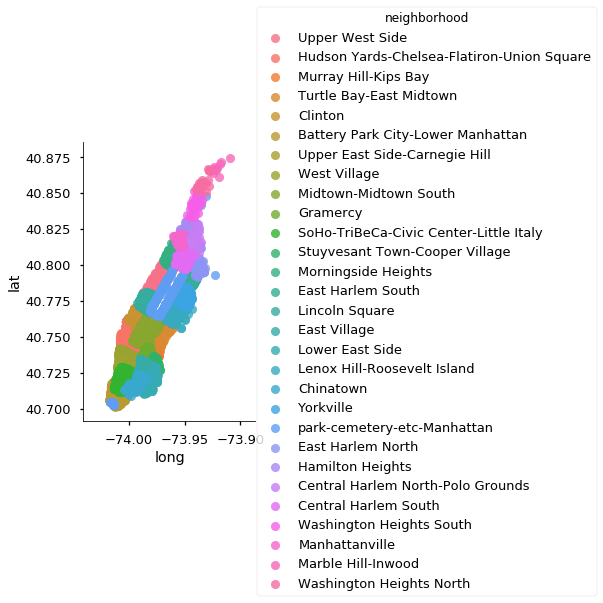

In [7]:
def visualize(dataset):
    dat = np.concatenate((dataset.loc[:, ['pickup_longitude', 'pickup_latitude']].as_matrix(),
                          dataset.loc[:, ['dropoff_longitude', 'dropoff_latitude']].as_matrix()))
    sns.regplot(dat[:, 0], dat[:, 1])
    plt.show()

def visualize_by_boro(dataset):
    pickups = dataset.loc[:, ["pickup_longitude", "pickup_latitude", "pickup_neighborhood_name"]]
    pickups.columns = ["long", "lat", "neighborhood"]
    dropoffs = dataset.loc[:, ["dropoff_longitude", "dropoff_latitude", "dropoff_neighborhood_name"]]
    dropoffs.columns = ["long", "lat", "neighborhood"]
    data = pd.concat((pickups, dropoffs)).dropna()
    sns.lmplot(x="long", y="lat", hue="neighborhood", data=data, fit_reg=False)
    plt.show()

indices = np.random.choice(manhattan.shape[0], size=10000, replace=False)

visualize_by_boro(manhattan.iloc[indices, :])

## Model

We will begin by trying to model the trip duration between two neighborhoods. Specifically, Morningside Heights and Upper East Side-Carnegie Hill

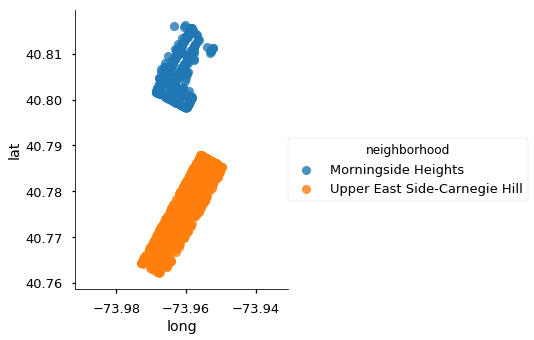

In [162]:
def get_neighborhood_to_neighborhood(source_neighborhood, sink_neighborhood, full_dataset):
    x = full_dataset.where((full_dataset["pickup_neighborhood_name"] == source_neighborhood) &
                           (full_dataset["dropoff_neighborhood_name"] == sink_neighborhood)).dropna()
    return x
    
def add_arrival_timestamp(x):
    x["dropoff_timestamp"] = x["pickup_timestamp"] + x["trip_duration"]
    return x

def add_dropoff_datetime(x):
    # This takes a while...
    x["dropoff_datetime"] = x["pickup_datetime"] + x["trip_duration"].apply(lambda x: pd.Timedelta(seconds=x))
    return x

def add_dropoff_hour(x):
    if "dropoff_datetime" not in x.columns:
        x = add_dropoff_datetime(x)
    x["dropoff_hour"] = x["dropoff_datetime"].apply(lambda x: x.hour)
    return x
    
def add_pickup_hour(x):
    x["pickup_hour"] = x["pickup_datetime"].apply(lambda x: x.hour)
    return x

manhattan = add_arrival_timestamp(manhattan)
ues_to_msh = get_neighborhood_to_neighborhood("Morningside Heights", "Upper East Side-Carnegie Hill", manhattan)
ues_to_msh = add_dropoff_hour(ues_to_msh)
ues_to_msh = add_pickup_hour(ues_to_msh)
visualize_by_boro(ues_to_msh)

Lets graph the trip duration by hour of day

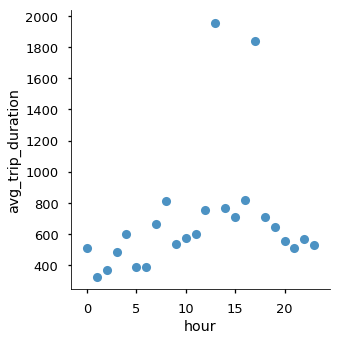

In [164]:
# note that the selection of the trip_duration column here is 
# arbitrary, the count would be the same regardless of column selected
avg_duration = ues_to_msh.groupby("dropoff_hour")["trip_duration"].mean().to_frame("avg_trip_duration")
avg_duration["hour"] = range(24)
sns.lmplot(x="hour", y="avg_trip_duration", data=avg_duration, fit_reg=False)
plt.show()

Lets model this with a simple GLM

In [170]:
# Get the dimensionality of our dataset
ues_to_msh = ues_to_msh.dropna()
x = ues_to_msh.drop(["Unnamed: 0", "id", "vendor_id", "pickup_datetime",
                             "store_and_fwd_flag", "trip_duration",
                             "pickup_boro", "pickup_boro_code", "pickup_neighborhood_name",
                             "pickup_neighborhood_code", "dropoff_boro", "dropoff_boro_code",
                             "dropoff_neighborhood_name", "dropoff_neighborhood_code",
                             "dropoff_timestamp", "dropoff_datetime",
                             "dropoff_hour", "pickup_hour"], axis=1).dropna()
y = ues_to_msh["trip_duration"].dropna()

N, D = x.shape
X = tf.placeholder(tf.float32, [N, D])
w = ed.models.Normal(loc=tf.zeros(D), scale=tf.ones(D))
b = ed.models.Normal(loc=tf.zeros(1), scale=tf.ones(1))
Y = ed.models.Normal(loc=ed.dot(X, w) + b, scale=tf.ones(N))

qw = ed.models.Normal(loc=tf.Variable(tf.random_normal([D])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([D]))))
qb = ed.models.Normal(loc=tf.Variable(tf.random_normal([1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))
print(y.as_matrix())
inference = ed.KLqp({w: qw, b: qb}, data={X: x.as_matrix(), Y: y.as_matrix()})
inference.run(n_samples=5, n_iter=250)

[  9.54000000e+02   4.08000000e+02   3.29000000e+02   1.13900000e+03
   1.57200000e+03   8.67000000e+02   5.30000000e+02   7.44000000e+02
   4.67000000e+02   9.26000000e+02   5.55000000e+02   1.62700000e+03
   7.47000000e+02   1.20800000e+03   8.38000000e+02   9.55000000e+02
   8.44000000e+02   5.41000000e+02   1.21800000e+03   8.76000000e+02
   1.33700000e+03   7.79000000e+02   6.69000000e+02   2.90000000e+02
   1.49500000e+03   5.16000000e+02   7.99000000e+02   1.08600000e+03
   6.11000000e+02   1.19300000e+03   9.72000000e+02   6.31000000e+02
   1.00900000e+03   1.02900000e+03   9.62000000e+02   7.51000000e+02
   6.18000000e+02   7.17000000e+02   1.21200000e+03   5.31000000e+02
   1.50900000e+03   9.82000000e+02   7.82000000e+02   4.70000000e+02
   7.90000000e+02   1.37600000e+03   1.50000000e+03   1.81800000e+03
   2.20000000e+03   7.00000000e+02   1.49200000e+03   7.96000000e+02
   1.53600000e+03   1.50800000e+03   1.36800000e+03   1.26000000e+03
   7.34000000e+02   1.52400000e+03

  1/250 [  0%]                                ETA: 616s | Loss: 895055663780262313984.000

InvalidArgumentError:  : Tensor had NaN values
	 [[Node: inference_140511183956736/3/VerifyFinite_57/CheckNumerics = CheckNumerics[T=DT_FLOAT, _class=["loc:@Normal_397/sample/Reshape"], message="", _device="/job:localhost/replica:0/task:0/cpu:0"](inference_140511183956736/3/Normal_1/sample/Reshape)]]

Caused by op 'inference_140511183956736/3/VerifyFinite_57/CheckNumerics', defined at:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/michael/Documents/ProbabilisticProgrammingProject/venv/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/michael/Documents/ProbabilisticProgrammingProject/venv/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/michael/Documents/ProbabilisticProgrammingProject/venv/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/michael/Documents/ProbabilisticProgrammingProject/venv/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/michael/Documents/ProbabilisticProgrammingProject/venv/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/michael/Documents/ProbabilisticProgrammingProject/venv/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/michael/Documents/ProbabilisticProgrammingProject/venv/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/michael/Documents/ProbabilisticProgrammingProject/venv/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/michael/Documents/ProbabilisticProgrammingProject/venv/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/michael/Documents/ProbabilisticProgrammingProject/venv/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/michael/Documents/ProbabilisticProgrammingProject/venv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/michael/Documents/ProbabilisticProgrammingProject/venv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/michael/Documents/ProbabilisticProgrammingProject/venv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/michael/Documents/ProbabilisticProgrammingProject/venv/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/michael/Documents/ProbabilisticProgrammingProject/venv/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/michael/Documents/ProbabilisticProgrammingProject/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/michael/Documents/ProbabilisticProgrammingProject/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2808, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/michael/Documents/ProbabilisticProgrammingProject/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-170-26d4190da790>", line 24, in <module>
    inference.run(n_samples=5, n_iter=250)
  File "/home/michael/Documents/ProbabilisticProgrammingProject/venv/lib/python3.6/site-packages/edward/inferences/inference.py", line 123, in run
    self.initialize(*args, **kwargs)
  File "/home/michael/Documents/ProbabilisticProgrammingProject/venv/lib/python3.6/site-packages/edward/inferences/klqp.py", line 86, in initialize
    return super(KLqp, self).initialize(*args, **kwargs)
  File "/home/michael/Documents/ProbabilisticProgrammingProject/venv/lib/python3.6/site-packages/edward/inferences/variational_inference.py", line 75, in initialize
    self.loss, grads_and_vars = self.build_loss_and_gradients(var_list)
  File "/home/michael/Documents/ProbabilisticProgrammingProject/venv/lib/python3.6/site-packages/edward/inferences/klqp.py", line 125, in build_loss_and_gradients
    return build_reparam_kl_loss_and_gradients(self, var_list)
  File "/home/michael/Documents/ProbabilisticProgrammingProject/venv/lib/python3.6/site-packages/edward/inferences/klqp.py", line 445, in build_reparam_kl_loss_and_gradients
    x_copy = copy(x, dict_swap, scope=scope)
  File "/home/michael/Documents/ProbabilisticProgrammingProject/venv/lib/python3.6/site-packages/edward/util/random_variables.py", line 228, in copy
    kwargs[key] = copy_default(value, dict_swap, scope, True, copy_q)
  File "/home/michael/Documents/ProbabilisticProgrammingProject/venv/lib/python3.6/site-packages/edward/util/random_variables.py", line 84, in copy_default
    x = copy(x, *args, **kwargs)
  File "/home/michael/Documents/ProbabilisticProgrammingProject/venv/lib/python3.6/site-packages/edward/util/random_variables.py", line 244, in copy
    new_op = copy(op, dict_swap, scope, True, copy_q)
  File "/home/michael/Documents/ProbabilisticProgrammingProject/venv/lib/python3.6/site-packages/edward/util/random_variables.py", line 308, in copy
    elem = copy(x, dict_swap, scope, True, copy_q)
  File "/home/michael/Documents/ProbabilisticProgrammingProject/venv/lib/python3.6/site-packages/edward/util/random_variables.py", line 244, in copy
    new_op = copy(op, dict_swap, scope, True, copy_q)
  File "/home/michael/Documents/ProbabilisticProgrammingProject/venv/lib/python3.6/site-packages/edward/util/random_variables.py", line 308, in copy
    elem = copy(x, dict_swap, scope, True, copy_q)
  File "/home/michael/Documents/ProbabilisticProgrammingProject/venv/lib/python3.6/site-packages/edward/util/random_variables.py", line 244, in copy
    new_op = copy(op, dict_swap, scope, True, copy_q)
  File "/home/michael/Documents/ProbabilisticProgrammingProject/venv/lib/python3.6/site-packages/edward/util/random_variables.py", line 308, in copy
    elem = copy(x, dict_swap, scope, True, copy_q)
  File "/home/michael/Documents/ProbabilisticProgrammingProject/venv/lib/python3.6/site-packages/edward/util/random_variables.py", line 244, in copy
    new_op = copy(op, dict_swap, scope, True, copy_q)
  File "/home/michael/Documents/ProbabilisticProgrammingProject/venv/lib/python3.6/site-packages/edward/util/random_variables.py", line 298, in copy
    elem = copy(x, dict_swap, scope, True, copy_q)
  File "/home/michael/Documents/ProbabilisticProgrammingProject/venv/lib/python3.6/site-packages/edward/util/random_variables.py", line 298, in copy
    elem = copy(x, dict_swap, scope, True, copy_q)
  File "/home/michael/Documents/ProbabilisticProgrammingProject/venv/lib/python3.6/site-packages/edward/util/random_variables.py", line 290, in copy
    op_def)
  File "/home/michael/Documents/ProbabilisticProgrammingProject/venv/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback):  : Tensor had NaN values
	 [[Node: inference_140511183956736/3/VerifyFinite_57/CheckNumerics = CheckNumerics[T=DT_FLOAT, _class=["loc:@Normal_397/sample/Reshape"], message="", _device="/job:localhost/replica:0/task:0/cpu:0"](inference_140511183956736/3/Normal_1/sample/Reshape)]]


## Inference

Perform variational inference.
Define the variational model to be a fully factorized normal.

In [5]:
qf = Normal(loc=tf.Variable(tf.random_normal([N])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([N]))))

Run variational inference for `500` iterations.

In [6]:
inference = ed.KLqp({f: qf}, data={X: X_train, y: y_train})
inference.run(n_iter=5000)

5000/5000 [100%] ██████████████████████████████ Elapsed: 9s | Loss: 82.755


In this case
`KLqp` defaults to minimizing the
$\text{KL}(q\|p)$ divergence measure using the reparameterization
gradient.
For more details on inference, see the [$\text{KL}(q\|p)$ tutorial](/tutorials/klqp).
(This example happens to be slow because evaluating and inverting full
covariances in Gaussian processes happens to be slow.)